### Capacitated Vehicle Routing Problem (CVRP): Finding the optimal solution using IBM CPLEX

<img src="http://neo.lcc.uma.es/dynamic/images/vrp.png" width="400" />

- $n$ is the number of clients
- $N$ is the set of clients, with $N=\{1,2,...,n\}$
- $V$ is the set of vertices (or nodes), with $V=\{0\}\cup N$
- $A$ is the set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is the cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$

Then, the formulation is the following

$$\begin{align}\
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , \ j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , \ i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \ * \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A\
\end{align}$$

$*$ $u_i$ is the cumulative demand up to point $i$: if arc $(i,j)$ is active $\Rightarrow$ the cumulative demand for the corresponding route up to point $i$ plus the demand at point $j$ must be equal to the cumulative demand up to point $j$.

In [1]:
import numpy as np

In [2]:
rnd = np.random
rnd.seed(0)

In [3]:
n = 10
Q = 20
N = [i for i in range(1, n+1)]
V = [0] + N
q = {i: rnd.randint(1, 10) for i in N}

print('N = {} \nV = {} \nq = {}'.format(N, V, q))

N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
q = {1: 6, 2: 1, 3: 4, 4: 4, 5: 8, 6: 4, 7: 6, 8: 3, 9: 5, 10: 8}


In [4]:
loc_x = rnd.rand(len(V))*200
loc_y = rnd.rand(len(V))*100

In [5]:
import matplotlib.pyplot as plt

Text(180.35460015641596, 77.81567509498505, 'Depot')

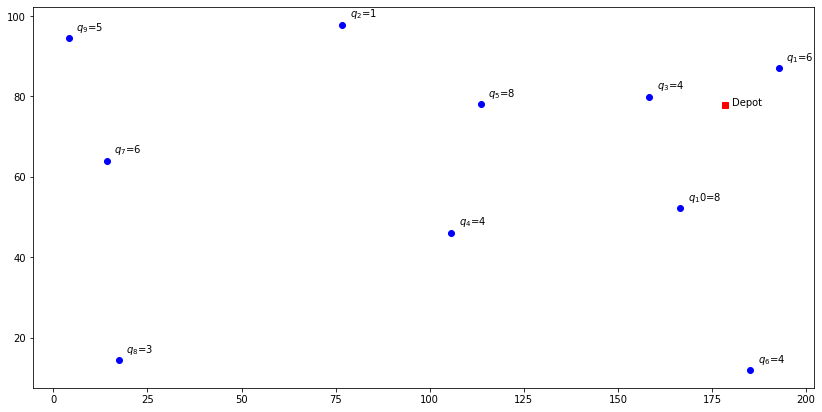

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# clients
ax.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
     ax.annotate('$q_{}$={}'.format(i, q[i]), (loc_x[i]+2, loc_y[i]+2))

# depot
ax.plot(loc_x[0], loc_y[0], c='r', marker='s')
ax.annotate('Depot', (loc_x[0]+2, loc_y[0]))

In [7]:
# arcs
A = [(i, j) for i in V for j in V if i != j]

# cost: Euclidean distance between nodes
c = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}
# np.hypot: Given the “legs” of a right triangle, return its hypotenuse. Equivalent to sqrt(x1**2 + x2**2).

In [8]:
from docplex.mp.model import Model

mdl = Model('CVRP')

In [9]:
x = mdl.binary_var_dict(A, name='x')

# display part of x
{(i,j): x[i,j] for i,j in A[0:3]}

{(0, 1): docplex.mp.Var(type=B,name='x_0_1'),
 (0, 2): docplex.mp.Var(type=B,name='x_0_2'),
 (0, 3): docplex.mp.Var(type=B,name='x_0_3')}

In [10]:
u = mdl.integer_var_dict(N, ub=Q, name='u')

# dispaly part of u
{k: u[k] for k in N[0:3]}

{1: docplex.mp.Var(type=I,name='u_1',ub=20),
 2: docplex.mp.Var(type=I,name='u_2',ub=20),
 3: docplex.mp.Var(type=I,name='u_3',ub=20)}

$u_i$ can be set as `continuous_var_ dict` too, but then some of its values in the optimal solution will not make sense!

In [11]:
mdl.minimize(mdl.sum(c[i, j]*x[i, j] for i, j in A))

mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i!=0 and j!=0)
mdl.add_constraints(u[i] >= q[i] for i in N)

mdl.parameters.timelimit = 15  # Sets the maximum time, in seconds, for a call to an optimizer

solution = mdl.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               15
Found incumbent of value 1784.255531 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 10 rows and 0 columns.
MIP Presolve modified 45 coefficients.
Aggregator did 45 substitutions.
Reduced MIP has 65 rows, 165 columns, and 335 nonzeros.
Reduced MIP has 110 binaries, 10 generals, 0 SOSs, and 90 indicators.
Presolve time = 0.00 sec. (0.36 ticks)
Probing time = 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 65 rows, 165 columns, and 335 nonzeros.
Reduced MIP has 110 binaries, 55 generals, 0 SOSs, and 90 indicators.
Presolve time = 0.02 sec. (0.24 ticks)
Probing time = 0.00 sec. (0.31 ticks)
Clique table members: 65.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Paral

In [12]:
print(solution)

solution for: CVRP
objective: 726.249
x_0_1=1
x_0_2=1
x_0_3=1
x_1_6=1
x_2_9=1
x_3_5=1
x_4_0=1
x_5_0=1
x_6_10=1
x_7_8=1
x_8_4=1
x_9_7=1
x_10_0=1
u_1=6
u_2=1
u_3=4
u_4=19
u_5=12
u_6=10
u_7=12
u_8=15
u_9=6
u_10=18



In [13]:
solution.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [14]:
active_arcs = [a for a in A if x[a].solution_value == 1]

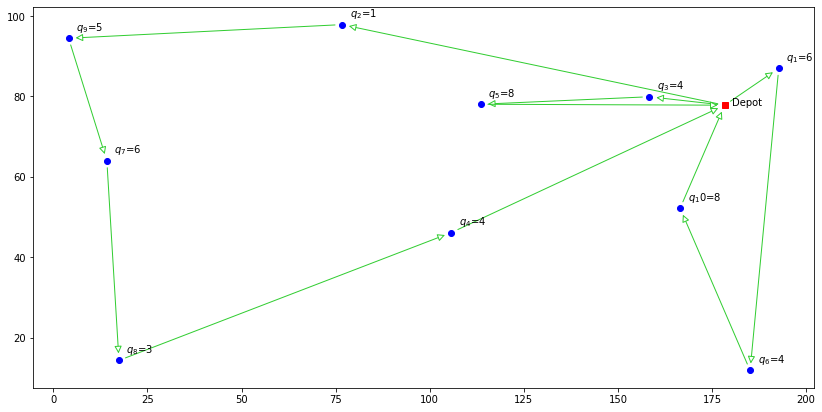

In [15]:
# update fig with optimal routes

from matplotlib.patches import ConnectionPatch
    
for A, B in active_arcs:
    xyA = (loc_x[A], loc_y[A])
    xyB = (loc_x[B], loc_y[B])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA, xyB, coordsA, coordsB,
                          arrowstyle="-|>", shrinkA=7, shrinkB=7,
                          mutation_scale=15, color="limegreen", fc="w")    
    ax.add_artist(con)

fig